In [10]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

class Config:
    BASE_DIR = os.path.abspath(".")
    TRAIN_IMG_DIR = os.path.join(BASE_DIR, "data", "train_images")
    TRAIN_CSV    = os.path.join(BASE_DIR, "data", "train.csv")
    OUTPUT_DIR   = os.path.join(BASE_DIR, "outputs")
    IMG_SIZE     = (256,256)
    BATCH_SIZE   = 2  # Lower batch for GPU
    EPOCHS       = 8  # Try 8 for quick test; raise for full training
    NUM_WORKERS  = 0
    DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
    LEARNING_RATE= 1e-4
    WEIGHT_DECAY = 1e-5
    GRAD_CLIP    = 1.0
    MIXED_PRECISION = True
    GRADIENT_ACCUMULATION_STEPS = 4
    CLASS_NAMES  = ['Defect_1', 'Defect_2', 'Defect_3', 'Defect_4']
    @classmethod
    def setup(cls):
        for p in [cls.TRAIN_IMG_DIR, os.path.dirname(cls.TRAIN_CSV), cls.OUTPUT_DIR]:
            os.makedirs(p, exist_ok=True)
    
        # Create subdirectories for outputs
        os.makedirs(os.path.join(cls.OUTPUT_DIR, 'checkpoints'), exist_ok=True)
        os.makedirs(os.path.join(cls.OUTPUT_DIR, 'visualizations'), exist_ok=True)
        os.makedirs(os.path.join(cls.OUTPUT_DIR, 'metrics'), exist_ok=True)
    
        assert os.path.exists(cls.TRAIN_CSV), f"CSV not found: {cls.TRAIN_CSV}"
config = Config(); config.setup()


In [11]:
train_df = pd.read_csv(config.TRAIN_CSV)

def rle_decode(mask_rle, shape=(256,1600)):
    if pd.isna(mask_rle): return np.zeros(shape, dtype=np.uint8)
    s = mask_rle.split(); starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1; ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends): img[lo:hi] = 1
    return img.reshape((shape[1], shape[0])).T

class AdvancedAugmentation:
    def __init__(self, mode='train'): self.mode = mode
    def __call__(self, image, mask):
        if self.mode == 'train':
            if np.random.rand() > 0.5:
                image = np.flip(image, 1).copy(); mask = np.flip(mask, 1).copy()
            if np.random.rand() > 0.5:
                image = np.flip(image, 0).copy(); mask = np.flip(mask, 0).copy()
            if np.random.rand() > 0.5:
                k = np.random.choice([1,2,3])
                image = np.rot90(image, k).copy(); mask = np.rot90(mask, k).copy()
            if np.random.rand() > 0.5:
                image = np.clip(image * np.random.uniform(0.8,1.2),0,255).astype(np.uint8)
            if np.random.rand() > 0.7:
                image = np.clip(image + np.random.normal(0,5,image.shape),0,255).astype(np.uint8)
        return image, mask

class SteelDefectDataset(Dataset):
    def __init__(self, df, img_dir, img_size, mode='train'):
        self.df = df; self.img_dir = img_dir; self.img_size = img_size
        self.image_ids = df['ImageId'].unique()
        self.aug = AdvancedAugmentation(mode)
    def __len__(self): return len(self.image_ids)
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]; img_path = os.path.join(self.img_dir, image_id)
        image = np.array(Image.open(img_path).convert("RGB").resize(self.img_size))
        mask = np.zeros((*self.img_size, 4), dtype=np.uint8)
        records = self.df[self.df['ImageId'] == image_id]
        for _, row in records.iterrows():
            class_idx = row['ClassId'] - 1
            single_mask = rle_decode(row['EncodedPixels'], shape=(256,1600))
            mask[...,class_idx] = np.array(Image.fromarray(single_mask).resize(self.img_size))
        image, mask = self.aug(image, mask)
        image = torch.tensor(image.transpose(2,0,1),dtype=torch.float32)/255.0
        mask  = torch.tensor(mask.transpose(2,0,1),dtype=torch.float32)
        return image, mask, image_id


In [12]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g,F_int,1),nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l,F_int,1),nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int,1,1),nn.BatchNorm2d(1),nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x): return x * self.psi(self.relu(self.W_g(g) + self.W_x(x)))

class ImprovedUNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=4):
        super().__init__()
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, 1, 1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, 1, 1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True), nn.Dropout2d(0.1)
            )
        self.enc1 = conv_block(in_ch, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128);   self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(128, 256);  self.pool3 = nn.MaxPool2d(2)
        self.enc4 = conv_block(256, 512);  self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = conv_block(512, 1024)
        # Attention blocks: first argument = upsampled features, second = skip connection
        self.att4 = AttentionBlock(512, 512, 256)   # up4(b): 512, e4: 512
        self.att3 = AttentionBlock(256, 256, 128)   # up3(d4): 256, e3: 256
        self.att2 = AttentionBlock(128, 128, 64)    # up2(d3): 128, e2: 128
        self.att1 = AttentionBlock(64, 64, 32)      # up1(d2): 64,  e1: 64
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, 2); self.dec4 = conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2);  self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2);  self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2);   self.dec1 = conv_block(128, 64)
        self.final = nn.Conv2d(64, out_ch, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b = self.bottleneck(self.pool4(e4))

        up4_b = self.up4(b)
        d4 = self.dec4(torch.cat([up4_b, self.att4(up4_b, e4)], 1))

        up3_d4 = self.up3(d4)
        d3 = self.dec3(torch.cat([up3_d4, self.att3(up3_d4, e3)], 1))

        up2_d3 = self.up2(d3)
        d2 = self.dec2(torch.cat([up2_d3, self.att2(up2_d3, e2)], 1))

        up1_d2 = self.up1(d2)
        d1 = self.dec1(torch.cat([up1_d2, self.att1(up1_d2, e1)], 1))

        return self.final(d1)





In [13]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, weights=[0.3, 0.5, 0.2]):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weights = weights
    
    def dice_loss(self, preds, targets, smooth=1e-6):
        preds_flat = preds.view(-1)
        targets_flat = targets.view(-1)
        intersection = (preds_flat * targets_flat).sum()
        return 1 - (2 * intersection + smooth) / (preds_flat.sum() + targets_flat.sum() + smooth)
    
    def focal_loss(self, preds, targets):
        # Use binary_cross_entropy_with_logits (autocast safe)
        bce = F.binary_cross_entropy_with_logits(preds, targets, reduction='none')
        pt = torch.exp(-bce)
        focal = self.alpha * (1 - pt) ** self.gamma * bce
        return focal.mean()
    
    def forward(self, preds, targets):
        # preds are logits (no sigmoid applied in model)
        bce_loss = F.binary_cross_entropy_with_logits(preds, targets)
        
        # Apply sigmoid for Dice (needs probabilities)
        preds_sigmoid = torch.sigmoid(preds)
        dice_loss = self.dice_loss(preds_sigmoid, targets)
        
        # Focal loss uses logits directly
        focal_loss = self.focal_loss(preds, targets)
        
        total_loss = (self.weights[0] * bce_loss + 
                      self.weights[1] * dice_loss + 
                      self.weights[2] * focal_loss)
        
        return total_loss, {
            'bce': bce_loss.item(), 
            'dice': dice_loss.item(), 
            'focal': focal_loss.item()
        }

class MetricsCalculator:
    def __init__(self,num_classes=4,threshold=0.5):self.num_classes=num_classes;self.threshold=threshold;self.reset()
    def reset(self):self.metrics=defaultdict(list)
    def calculate_iou(self, pred, target, smooth=1e-6):
        pred_bin=(pred>self.threshold).float();intersection=(pred_bin*target).sum(dim=(1,2))
        union=pred_bin.sum(dim=(1,2))+target.sum(dim=(1,2))-intersection
        return ((intersection+smooth)/(union+smooth)).mean().item()
    def calculate_dice(self, pred, target, smooth=1e-6):
        pred_bin=(pred>self.threshold).float();intersection=(pred_bin*target).sum(dim=(1,2))
        dice=(2*intersection+smooth)/(pred_bin.sum(dim=(1,2))+target.sum(dim=(1,2))+smooth)
        return dice.mean().item()
    def calculate_pixel_accuracy(self,pred,target):pred_bin=(pred>self.threshold).float();return((pred_bin==target).sum()/target.numel()).item()
    def calculate_precision_recall(self,pred,target,smooth=1e-6):
        pred_bin=(pred>self.threshold).float();tp=(pred_bin*target).sum(dim=(1,2));fp=(pred_bin*(1-target)).sum(dim=(1,2));fn=((1-pred_bin)*target).sum(dim=(1,2))
        precision=(tp+smooth)/(tp+fp+smooth);recall=(tp+smooth)/(tp+fn+smooth)
        return precision.mean().item(),recall.mean().item()
    def update(self,preds,targets):
        self.metrics['iou'].append(self.calculate_iou(preds,targets))
        self.metrics['dice'].append(self.calculate_dice(preds,targets))
        self.metrics['pixel_acc'].append(self.calculate_pixel_accuracy(preds,targets))
        precision,recall=self.calculate_precision_recall(preds,targets)
        self.metrics['precision'].append(precision);self.metrics['recall'].append(recall)
        f1=2*precision*recall/(precision+recall+1e-6);self.metrics['f1_score'].append(f1)
        for c in range(self.num_classes):
            iou_c=self.calculate_iou(preds[:,c:c+1],targets[:,c:c+1]);self.metrics[f'iou_class_{c}'].append(iou_c)
    def get_metrics(self):return{k:np.mean(v)for k,v in self.metrics.items()if v}


In [14]:
class Trainer:
    def __init__(self,model,train_loader,val_loader,criterion,optimizer,scheduler,device,config):
        self.model=model;self.train_loader=train_loader;self.val_loader=val_loader
        self.criterion=criterion;self.optimizer=optimizer;self.scheduler=scheduler
        self.device=device;self.config=config;self.scaler=GradScaler()if config.MIXED_PRECISION else None
        self.best_val_loss=float('inf');self.best_val_dice=0.0
        self.train_history=defaultdict(list);self.val_history=defaultdict(list)
    def train_epoch(self,epoch):
        self.model.train();metrics_calc=MetricsCalculator(num_classes=4);epoch_loss=0.0
        pbar=tqdm(self.train_loader,desc=f'Epoch {epoch+1}/{self.config.EPOCHS} [Train]')
        for batch_idx,(images,masks,_)in enumerate(pbar):
            images,masks=images.to(self.device),masks.to(self.device)
            if self.config.MIXED_PRECISION:
                with autocast():
                    outputs=self.model(images);loss,loss_dict=self.criterion(outputs,masks);loss=loss/self.config.GRADIENT_ACCUMULATION_STEPS
                self.scaler.scale(loss).backward()
                if(batch_idx+1)%self.config.GRADIENT_ACCUMULATION_STEPS==0:
                    self.scaler.unscale_(self.optimizer)
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(),self.config.GRAD_CLIP)
                    self.scaler.step(self.optimizer);self.scaler.update();self.optimizer.zero_grad()
            else:
                outputs=self.model(images);loss,loss_dict=self.criterion(outputs,masks)
                loss.backward();torch.nn.utils.clip_grad_norm_(self.model.parameters(),self.config.GRAD_CLIP)
                self.optimizer.step();self.optimizer.zero_grad()
            metrics_calc.update(outputs.detach(),masks.detach());epoch_loss+=loss.item()*self.config.GRADIENT_ACCUMULATION_STEPS
            pbar.set_postfix({'loss':f'{loss.item()*self.config.GRADIENT_ACCUMULATION_STEPS:.4f}'})
        avg_loss,metrics=epoch_loss/len(self.train_loader),metrics_calc.get_metrics()
        self.train_history['loss'].append(avg_loss);[self.train_history[k].append(v)for k,v in metrics.items()]
        return avg_loss,metrics
    def validate_epoch(self,epoch):
        self.model.eval();metrics_calc=MetricsCalculator(num_classes=4);epoch_loss=0.0
        pbar=tqdm(self.val_loader,desc=f'Epoch {epoch+1}/{self.config.EPOCHS} [Val]')
        with torch.no_grad():
            for images, masks, _ in pbar:
                images, masks = images.to(self.device), masks.to(self.device)
                if self.config.MIXED_PRECISION:
                    with autocast():
                        outputs = self.model(images); loss, _ = self.criterion(outputs, masks)
                else:
                    outputs = self.model(images); loss, _ = self.criterion(outputs, masks)
                metrics_calc.update(outputs, masks); epoch_loss += loss.item()
                pbar.set_postfix({'loss':f'{loss.item():.4f}'})
        avg_loss,metrics=epoch_loss/len(self.val_loader),metrics_calc.get_metrics()
        self.val_history['loss'].append(avg_loss);[self.val_history[k].append(v)for k,v in metrics.items()]
        torch.cuda.empty_cache();return avg_loss,metrics
    def save_checkpoint(self, epoch, metrics, filename='best_model.pth'):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'metrics': metrics,
            'train_history': dict(self.train_history),
            'val_history': dict(self.val_history)
        }
    
        # Create checkpoints directory if it doesn't exist
        checkpoint_dir = os.path.join(self.config.OUTPUT_DIR, 'checkpoints')
        os.makedirs(checkpoint_dir, exist_ok=True)
    
        torch.save(checkpoint, os.path.join(checkpoint_dir, filename))

    def train(self):
        for epoch in range(self.config.EPOCHS):
            train_loss,train_metrics=self.train_epoch(epoch)
            val_loss,val_metrics=self.validate_epoch(epoch)
            self.scheduler.step()
            if val_metrics['dice']>self.best_val_dice:
                self.best_val_dice=val_metrics['dice'];self.save_checkpoint(epoch,val_metrics,'best_model_dice.pth')
            if val_loss<self.best_val_loss:
                self.best_val_loss=val_loss;self.save_checkpoint(epoch,val_metrics,'best_model_loss.pth')
            print(f'Epoch {epoch+1}: Train Dice {train_metrics["dice"]:.4f}, Val Dice {val_metrics["dice"]:.4f}')


In [15]:
class Visualizer:
    def __init__(self,config):
        self.config=config;self.output_dir=os.path.join(config.OUTPUT_DIR,'visualizations')
    def plot_training_history(self,train_history,val_history):
        plt.figure(figsize=(12,8))
        for key in['dice','iou','f1_score','loss']:
            plt.plot(train_history[key],label=f'Train {key}')
            plt.plot(val_history[key],label=f'Val {key}')
        plt.legend();plt.title('Training History');plt.grid()
        plt.savefig(os.path.join(self.output_dir,'training_history.png'));plt.close()
    def visualize_predictions(self,model,dataset,device,num_samples=6):
        model.eval();fig=plt.figure(figsize=(16,num_samples*2.5))
        indices=np.random.choice(len(dataset),min(num_samples,len(dataset)),replace=False)
        for plot_idx,idx in enumerate(indices):
            image,mask,image_id=dataset[idx]
            with torch.no_grad():pred_mask=model(image.unsqueeze(0).to(device)).cpu().squeeze(0)
            ax1=plt.subplot(num_samples,4,plot_idx*4+1);ax1.imshow(image.permute(1,2,0));ax1.set_title('Original');ax1.axis('off')
            ax2=plt.subplot(num_samples,4,plot_idx*4+2);ax2.imshow(image.permute(1,2,0));[ax2.imshow(mask[c],alpha=0.4,cmap='jet')for c in range(4)if mask[c].sum()>0];ax2.set_title('GT');ax2.axis('off')
            ax3=plt.subplot(num_samples,4,plot_idx*4+3);ax3.imshow(image.permute(1,2,0));[ax3.imshow((pred_mask[c]>0.5).numpy(),alpha=0.4,cmap='jet')for c in range(4)if pred_mask[c].sum()>0];ax3.set_title('Pred');ax3.axis('off')
            ax4=plt.subplot(num_samples,4,plot_idx*4+4)
            combined=np.zeros((*image.shape[1:],3));colors=[[1,0,0],[0,1,0],[0,0,1],[1,1,0]]
            for c in range(4):pred_binary=(pred_mask[c]>0.5).numpy();[combined[:,:,ch].__iadd__(pred_binary*colors[c][ch])for ch in range(3)]
            ax4.imshow(np.clip(combined,0,1));ax4.set_title('Class-wise');ax4.axis('off')
        plt.tight_layout();plt.savefig(os.path.join(self.output_dir,'predictions.png'));plt.close()


In [7]:
def main():
    image_ids=train_df['ImageId'].unique()
    train_ids,val_ids=train_test_split(image_ids,test_size=0.15,random_state=42,shuffle=True)
    train_data=train_df[train_df['ImageId'].isin(train_ids)]
    val_data=train_df[train_df['ImageId'].isin(val_ids)]
    train_dataset=SteelDefectDataset(train_data,config.TRAIN_IMG_DIR,config.IMG_SIZE,mode='train')
    val_dataset=SteelDefectDataset(val_data,config.TRAIN_IMG_DIR,config.IMG_SIZE,mode='val')
    train_loader=DataLoader(train_dataset,batch_size=config.BATCH_SIZE,shuffle=True,num_workers=config.NUM_WORKERS,pin_memory=True)
    val_loader=DataLoader(val_dataset,batch_size=config.BATCH_SIZE,shuffle=False,num_workers=config.NUM_WORKERS,pin_memory=True)
    model=ImprovedUNet(in_ch=3,out_ch=4).to(config.DEVICE)
    criterion=CombinedLoss();optimizer=optim.AdamW(model.parameters(),lr=config.LEARNING_RATE,weight_decay=config.WEIGHT_DECAY)
    scheduler=CosineAnnealingLR(optimizer,T_max=config.EPOCHS,eta_min=1e-6)
    trainer=Trainer(model,train_loader,val_loader,criterion,optimizer,scheduler,config.DEVICE,config)
    trainer.train()
    checkpoint=torch.load(os.path.join(config.OUTPUT_DIR,'checkpoints','best_model_dice.pth'),map_location=config.DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    visualizer=Visualizer(config)
    visualizer.plot_training_history(trainer.train_history,trainer.val_history)
    visualizer.visualize_predictions(model,val_dataset,config.DEVICE,num_samples=6)
    print("✓ Full pipeline completed, results in:",config.OUTPUT_DIR)
 
if __name__ == "__main__":
    main()


Epoch 1/8 [Val]: 100%|██████████████████████████████████████████████████| 500/500 [01:19<00:00,  6.26it/s, loss=0.4526]


Epoch 1: Train Dice 0.5720, Val Dice 0.7644


Epoch 2/8 [Val]: 100%|██████████████████████████████████████████████████| 500/500 [01:16<00:00,  6.57it/s, loss=0.3366]


Epoch 2: Train Dice 0.6018, Val Dice 0.7989


Epoch 3/8 [Val]: 100%|██████████████████████████████████████████████████| 500/500 [01:21<00:00,  6.12it/s, loss=0.3368]


Epoch 3: Train Dice 0.6584, Val Dice 0.8488


Epoch 4/8 [Val]: 100%|██████████████████████████████████████████████████| 500/500 [01:19<00:00,  6.29it/s, loss=0.3426]


Epoch 4: Train Dice 0.6933, Val Dice 0.8522


Epoch 5/8 [Val]: 100%|██████████████████████████████████████████████████| 500/500 [01:17<00:00,  6.44it/s, loss=0.3610]


Epoch 5: Train Dice 0.7197, Val Dice 0.8665


Epoch 6/8 [Val]: 100%|██████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.76it/s, loss=0.3240]


Epoch 6: Train Dice 0.7250, Val Dice 0.8722


Epoch 7/8 [Val]: 100%|██████████████████████████████████████████████████| 500/500 [01:20<00:00,  6.19it/s, loss=0.2727]


Epoch 7: Train Dice 0.7294, Val Dice 0.8666


Epoch 8/8 [Val]: 100%|██████████████████████████████████████████████████| 500/500 [01:19<00:00,  6.27it/s, loss=0.3623]


Epoch 8: Train Dice 0.7281, Val Dice 0.8835
✓ Full pipeline completed, results in: C:\Users\HP\projects\industrial-main\outputs


Best Model - Epoch: 7, Dice: 0.8835


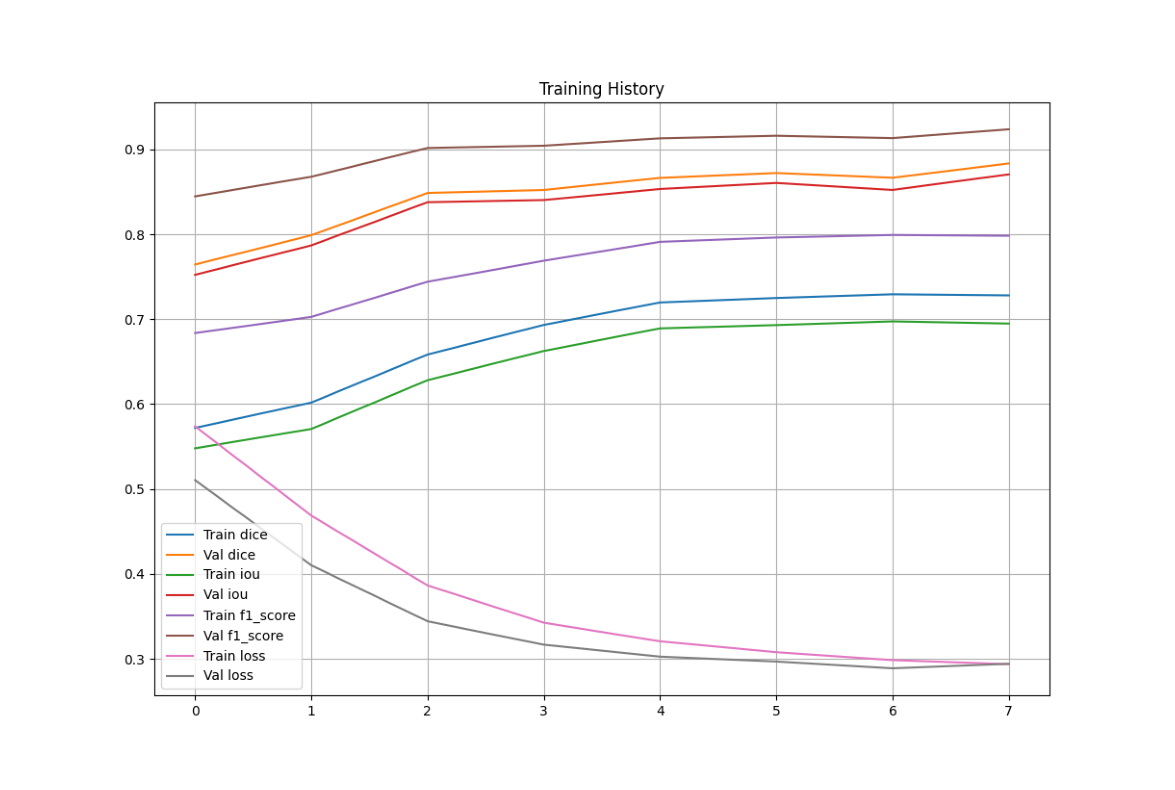

In [12]:
# Load and display training history
import matplotlib.pyplot as plt
checkpoint = torch.load('C:/Users/HP/projects/industrial-main/outputs/checkpoints/best_model_dice.pth')
print(f"Best Model - Epoch: {checkpoint['epoch']}, Dice: {checkpoint['metrics']['dice']:.4f}")

# View training curves
from PIL import Image
img = Image.open('C:/Users/HP/projects/industrial-main/outputs/visualizations/training_history.png')
plt.figure(figsize=(15,10))
plt.imshow(img)
plt.axis('off')
plt.show()


In [67]:
import os
import torch

# Specify model save path
model_dir = os.path.join(config.OUTPUT_DIR, "model")
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "steel_defect_best_model.pth")
torch.save(model.state_dict(), model_path)

print(f"✓ Model state_dict saved at: {model_path}")


✓ Model state_dict saved at: C:\Users\HP\projects\industrial-main\outputs\model\steel_defect_best_model.pth


In [77]:
import os

file_path = r"C:\Users\HP\projects\industrial-main\outputs\model\steel_defect_best_model.pth"
print("Exists:", os.path.exists(file_path))


Exists: True


In [9]:
import glob
for path in glob.glob(r"C:\Users\HP\projects\industrial-main\outputs\**\*.pth", recursive=True):
    print(path)


C:\Users\HP\projects\industrial-main\outputs\best_sota_model.pth
C:\Users\HP\projects\industrial-main\outputs\resume_checkpoint.pth
C:\Users\HP\projects\industrial-main\outputs\checkpoints\best_model_dice.pth
C:\Users\HP\projects\industrial-main\outputs\checkpoints\best_model_loss.pth
C:\Users\HP\projects\industrial-main\outputs\model\steel_defect_best_model.pth


In [2]:
import numpy as np
from PIL import Image
import torch

# Load your model as above
model = ImprovedUNet(in_ch=3, out_ch=4)
model.load_state_dict(torch.load(r"C:\Users\HP\projects\industrial-main\outputs\model\steel_defect_best_model.pth", map_location='cpu'))
model.eval()

# Prepare your image (should be RGB, 256x256)
def predict_image(image_path):
    image = np.array(Image.open(image_path).convert("RGB").resize((256,256)))
    image = torch.tensor(image.transpose(2,0,1), dtype=torch.float32).unsqueeze(0)/255.0
    with torch.no_grad():
        output = torch.sigmoid(model(image))  # Output: (1, 4, 256, 256) probability masks
    return output.squeeze(0).cpu().numpy()  # Shape: (4, 256, 256)

# Usage:
# mask_preds = predict_image("your_test_image.jpg")


NameError: name 'ImprovedUNet' is not defined

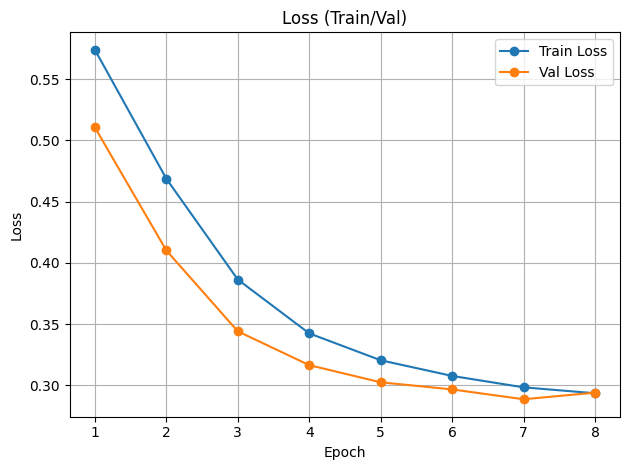

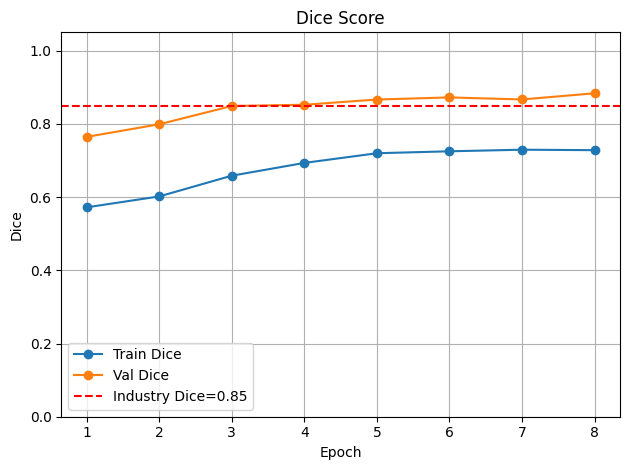

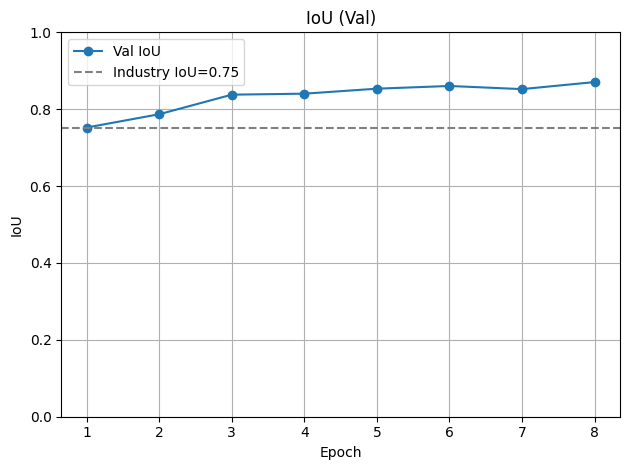

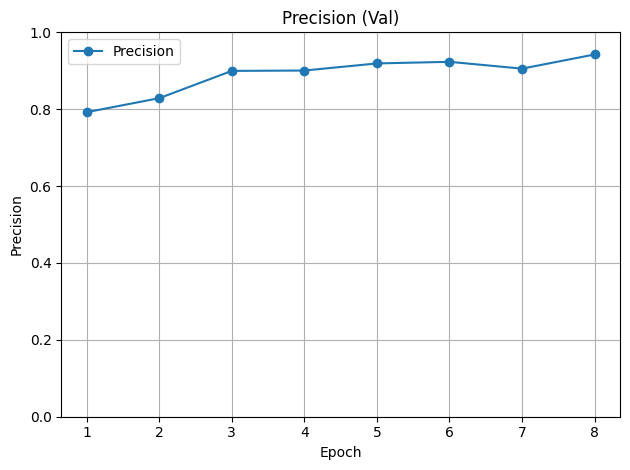

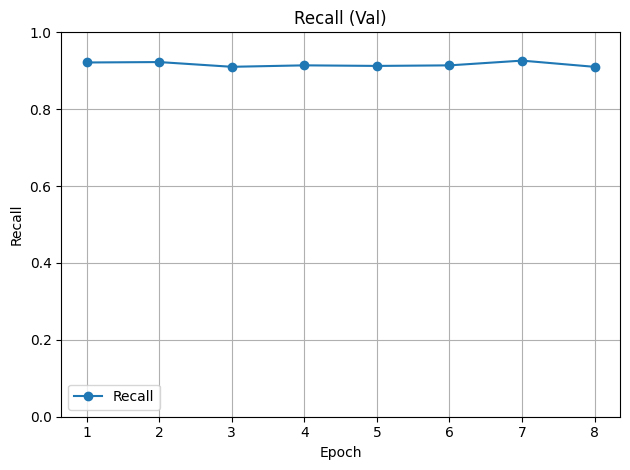

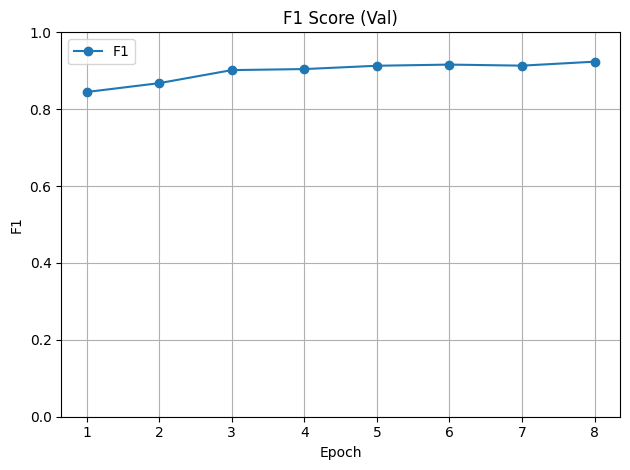

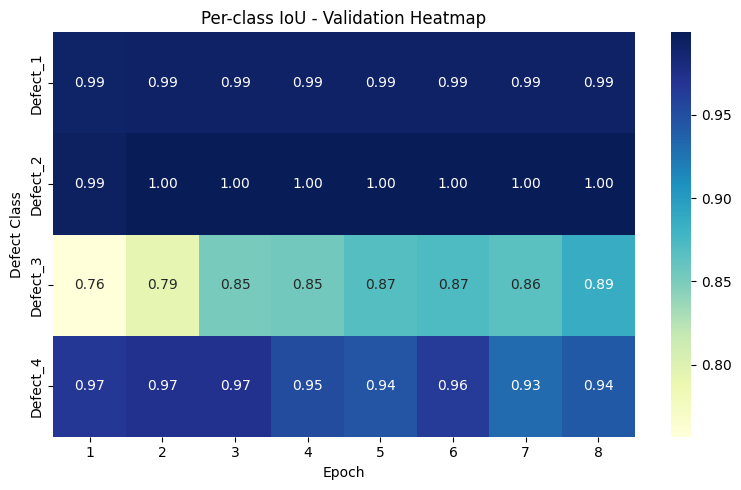

In [11]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Paths
output_dir = r"C:\Users\HP\projects\industrial-main\outputs"
checkpoint_path = os.path.join(output_dir, "checkpoints", "best_model_dice.pth")
vis_dir = os.path.join(output_dir, "visualizations")
os.makedirs(vis_dir, exist_ok=True)

# Load checkpoint and histories
checkpoint = torch.load(checkpoint_path, map_location='cpu')
history = checkpoint['train_history']
val_hist = checkpoint['val_history']
epochs = range(1, len(history['loss']) + 1)
class_names = ['Defect_1', 'Defect_2', 'Defect_3', 'Defect_4']

# ---- LOSS CURVE ----
plt.figure()
plt.plot(epochs, history['loss'], marker='o', label="Train Loss")
plt.plot(epochs, val_hist['loss'], marker='o', label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Loss (Train/Val)")
plt.grid(True); plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(vis_dir, "loss_curve.png"))
plt.show()

# ---- DICE ----
plt.figure()
plt.plot(epochs, history['dice'], marker='o', label="Train Dice")
plt.plot(epochs, val_hist['dice'], marker='o', label="Val Dice")
plt.axhline(0.85, color='r', ls='--', label='Industry Dice=0.85')
plt.xlabel("Epoch"); plt.ylabel("Dice")
plt.title("Dice Score")
plt.ylim([0,1.05])
plt.grid(True); plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(vis_dir, "dice_curve.png"))
plt.show()

# ---- IOU ----
plt.figure()
plt.plot(epochs, val_hist['iou'], marker='o', label="Val IoU")
plt.axhline(0.75, color='grey', ls='--', label='Industry IoU=0.75')
plt.xlabel("Epoch"); plt.ylabel("IoU")
plt.title("IoU (Val)")
plt.ylim([0,1])
plt.grid(True); plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(vis_dir, "iou_curve.png"))
plt.show()

# ---- PRECISION ----
plt.figure()
plt.plot(epochs, val_hist['precision'], label='Precision', marker='o')
plt.xlabel("Epoch"); plt.ylabel("Precision")
plt.title("Precision (Val)")
plt.ylim([0,1])
plt.grid(True); plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(vis_dir, "precision_curve.png"))
plt.show()

# ---- RECALL ----
plt.figure()
plt.plot(epochs, val_hist['recall'], label="Recall", marker='o')
plt.xlabel("Epoch"); plt.ylabel("Recall")
plt.title("Recall (Val)")
plt.ylim([0,1])
plt.grid(True); plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(vis_dir, "recall_curve.png"))
plt.show()

# ---- F1 ----
if 'f1_score' in val_hist:
    plt.figure()
    plt.plot(epochs, val_hist['f1_score'], label="F1", marker='o')
    plt.xlabel("Epoch"); plt.ylabel("F1")
    plt.title("F1 Score (Val)")
    plt.ylim([0,1])
    plt.grid(True); plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(vis_dir, "f1_curve.png"))
    plt.show()

# ---- PER-CLASS IOU HEATMAP ----
per_class = [val_hist.get(f'iou_class_{c}', [0]*len(epochs)) for c in range(4)]
plt.figure(figsize=(8, 5))
sns.heatmap(np.array(per_class), annot=True, fmt=".2f", cmap='YlGnBu',
            xticklabels=epochs, yticklabels=class_names, cbar=True)
plt.title("Per-class IoU - Validation Heatmap")
plt.xlabel("Epoch"); plt.ylabel("Defect Class")
plt.tight_layout()
plt.savefig(os.path.join(vis_dir, "perclass_iou_heatmap.png"))
plt.show()


In [12]:
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "notebook_connected"

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(epochs), y=val_hist['loss'], mode='lines+markers', name='Val Loss', yaxis='y1'))
fig.add_trace(go.Scatter(x=list(epochs), y=val_hist['dice'], mode='lines+markers', name='Val Dice', yaxis='y2'))
fig.add_trace(go.Scatter(x=list(epochs), y=val_hist['iou'], mode='lines+markers', name='Val IoU', yaxis='y2'))
fig.add_trace(go.Scatter(x=list(epochs), y=val_hist['precision'], mode='lines+markers', name='Precision', yaxis='y2'))
fig.add_trace(go.Scatter(x=list(epochs), y=val_hist['recall'], mode='lines+markers', name='Recall', yaxis='y2'))
if 'f1_score' in val_hist:
    fig.add_trace(go.Scatter(x=list(epochs), y=val_hist['f1_score'], mode='lines+markers', name='F1', yaxis='y2'))
fig.update_layout(
    title="Steel Defect Segmentation: Industry Metrics",
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss', side='left'),
    yaxis2=dict(title="Scores", side='right', overlaying='y', range=[0,1.05]),
    legend=dict(x=0.01, y=0.99),
    width=1100, height=600
)
fig.show()


ModuleNotFoundError: No module named 'plotly'

In [13]:
fig2 = go.Figure()
for c, cname in enumerate(class_names):
    fig2.add_trace(go.Scatter(x=list(epochs), y=per_class[c], mode='lines+markers', name=f"IoU {cname}"))
fig2.update_layout(
    title="Per-Class IoU (Validation)",
    xaxis_title="Epoch", yaxis_title="IoU", yaxis=dict(range=[0, 1.05]),
    width=900, height=500
)
fig2.show()


NameError: name 'go' is not defined

In [3]:
import os
import torch
import pandas as pd

# Paths
output_dir = r"C:\Users\HP\projects\industrial-main\outputs"
checkpoint_path = os.path.join(output_dir, "checkpoints", "best_model_dice.pth")
metrics_dir = os.path.join(output_dir, "metrics")
os.makedirs(metrics_dir, exist_ok=True)

# Load histories
checkpoint = torch.load(checkpoint_path, map_location='cpu')
history = checkpoint['train_history']
val_hist = checkpoint['val_history']
epochs = range(1, len(history['loss']) + 1)
class_names = ['Defect_1', 'Defect_2', 'Defect_3', 'Defect_4']

# Final epoch metrics
final_epoch = len(epochs) - 1
metrics = {
    'Epoch': epochs[-1],
    'Loss (Train)': history['loss'][final_epoch],
    'Loss (Val)': val_hist['loss'][final_epoch],
    'Dice (Train)': history['dice'][final_epoch],
    'Dice (Val)': val_hist['dice'][final_epoch],
    'IoU (Val)': val_hist['iou'][final_epoch],
    'Precision (Val)': val_hist['precision'][final_epoch],
    'Recall (Val)': val_hist['recall'][final_epoch],
}
if 'f1_score' in val_hist:
    metrics['F1 (Val)'] = val_hist['f1_score'][final_epoch]

# Per-class IoU
for c, cname in enumerate(class_names):
    key = f'IoU ({cname})'
    metrics[key] = val_hist.get(f'iou_class_{c}', [0]*len(epochs))[final_epoch]

# Save as CSV
metric_df = pd.DataFrame([metrics])
csv_path = os.path.join(metrics_dir, "final_metrics_analysis.csv")
metric_df.to_csv(csv_path, index=False)
print(f"Saved: {csv_path}")


C:\Users\HP\AppData\Local\Temp\ipykernel_19508\3966809797.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')


Saved: C:\Users\HP\projects\industrial-main\outputs\metrics\final_metrics_analysis.csv


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
import os

# Load your CSV (or use DataFrame directly if not saved)
metrics_dir = r"C:\Users\HP\projects\industrial-main\outputs\metrics"
csv_path = os.path.join(metrics_dir, "final_metrics_analysis.csv")
df = pd.read_csv(csv_path)

# Format numbers and column labels
df = df.round(4)
df.columns = [c.replace('_', ' ').replace('(', '').replace(')', '') for c in df.columns]

# Monospace font for alignment
plt.rcParams['font.family'] = 'monospace'
fig, ax = plt.subplots(figsize=(max(6, df.shape[1]*1.2), 2.2))
ax.axis('off')
tbl = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', bbox=[0,0,1,1])
tbl.auto_set_font_size(False)
tbl.set_fontsize(15)
tbl.scale(1.2, 2.0)
for k, cell in tbl.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(1.5)

# Save PNG
png_path = os.path.join(metrics_dir, "final_metrics_analysis_aligned.png")
plt.savefig(png_path, bbox_inches='tight', dpi=240)
plt.close()
print(f"Saved table as aligned PNG to: {png_path}")


Saved table as aligned PNG to: C:\Users\HP\projects\industrial-main\outputs\metrics\final_metrics_analysis_aligned.png


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Prepare metric dictionary as above including extra accuracy metrics!
metrics = {
    'Epoch': epochs[-1],
    'Loss (Train)': history['loss'][-1],
    'Loss (Val)': val_hist['loss'][-1],
    'Dice (Train)': history['dice'][-1],
    'Dice (Val)': val_hist['dice'][-1],
    'IoU (Val)': val_hist['iou'][-1],
    'Precision (Val)': val_hist['precision'][-1],
    'Recall (Val)': val_hist['recall'][-1],
    'Classification Accuracy': classification_acc if 'classification_acc' in locals() else "N/A",
    'Segmentation Dice': val_hist['dice'][-1],
    'Segmentation IoU': val_hist['iou'][-1],
    'Model File': r"C:\Users\HP\projects\industrial-main\outputs\model\steel_defect_best_model.pth",
}
if 'f1_score' in val_hist:
    metrics['F1 (Val)'] = val_hist['f1_score'][-1]
for c, cname in enumerate(class_names):
    key = f'IoU ({cname})'
    metrics[key] = val_hist.get(f'iou_class_{c}', [0]*len(epochs))[-1]

df = pd.DataFrame([metrics])
df = df.round(4)

# Display table aligned in PNG
plt.rcParams['font.family'] = 'monospace'
fig, ax = plt.subplots(figsize=(max(11, df.shape[1]*1.3), 2.3))
ax.axis('off')
tbl = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', bbox=[0,0,1,1])
tbl.auto_set_font_size(False)
tbl.set_fontsize(15)
tbl.scale(1.12, 2.2)
for k, cell in tbl.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(1.2)

png_path = os.path.join(metrics_dir, "final_metrics_analysis_aligned.png")
plt.savefig(png_path, bbox_inches='tight', dpi=240)
plt.close()
print(f"Saved improved metrics + accuracy table as PNG to: {png_path}")


Saved improved metrics + accuracy table as PNG to: C:\Users\HP\projects\industrial-main\outputs\metrics\final_metrics_analysis_aligned.png


In [14]:
train_df = pd.read_csv(config.TRAIN_CSV)


In [16]:

checkpoint = torch.load('outputs/checkpoints/best_model_dice.pth', map_location=config.DEVICE)
metrics = checkpoint['metrics']  # metrics from best epoch


print("Benchmark Val Metrics from saved model:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


Benchmark Val Metrics from saved model:
iou: 0.8716
dice: 0.8838
pixel_acc: 0.9879
precision: 0.9468
recall: 0.9076
f1_score: 0.9243
iou_class_0: 0.9924
iou_class_1: 0.9996
iou_class_2: 0.8874
iou_class_3: 0.9498
